In [5]:
import numpy as np 
import matplotlib.pyplot as plt
import tensorflow as tf

In [43]:
n_visible =784
n_hidden = 50
hidden_bias = np.random.randn(n_hidden)
visible_bias = np.random.randn(n_visible)
v0_state = np.zeros(n_visible, np.float32)
W = np.zeros((n_visible, n_hidden), np.float32)



In [44]:
#temp
a = np.array([[1, 2, 3], [5, 6, 7], [8, 9, 10]])
b = np.array([[1], [2], [3]])
c = np.dot(a, b)
c = a @ b
print(type(c))
print(c)


<class 'numpy.ndarray'>
[[14]
 [38]
 [56]]


In [45]:
def sigmoid(X):
        return tf.nn.sigmoid(X)
def relu(X):
    return np.maximum(X, 0)

In [46]:
print(v0_state.shape)

(784,)


In [47]:
#computing the hidden nodes probability vector
# h0_prob = sigmoid(([v0_state] @ W) + hidden_bias); 
# print(h0_prob.shape)
# print(type(h0_prob))
# print("first 15 hidden probs: ", h0_prob[0][:15])

v0_state = tf.Variable(tf.zeros([784]), tf.float32)
#return only the generated hidden states
def hidden_layer(v0_state, W, hb):
    h0_prob = tf.nn.sigmoid(tf.matmul([v0_state], W) + hb)  #probabilities of the hidden units
    h0_state = tf.nn.relu(tf.sign(h0_prob - tf.random.uniform(tf.shape(h0_prob)))) #sample_h_given_X
    return h0_state
h0_state  = hidden_layer(v0_state, W, hidden_bias)

print(f'first 15 hidden states:{h0_state[:15]}')
print(h0_state.shape)
    

first 15 hidden states:[[1. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 0. 0. 1. 1. 0. 0. 1. 0. 1. 1. 1. 0.
  0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 1. 1. 0. 1. 0. 1. 1.
  1. 1.]]
(1, 50)


2024-02-25 20:21:36.372596: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


In [48]:
#reconstruction from hidden nodes
def reconstructed_output(h0_state, W, vb):
    v1_prob = tf.nn.sigmoid(tf.matmul(h0_state, tf.transpose(W)) + vb) 
    v1_state = tf.nn.relu(tf.sign(v1_prob - tf.random.uniform(tf.shape(v1_prob)))) #sample_v_given_h
 
    return v1_state[0]


v1_state = reconstructed_output(h0_state, W, visible_bias)
print("hidden state shape:" ,h0_state.shape)
print("v1 state shape:", v1_state.shape)
print(v1_state[:5])

hidden state shape: (1, 50)
v1 state shape: (784,)
tf.Tensor([1. 1. 1. 1. 1.], shape=(5,), dtype=float32)


<h2>Goal</h2>
 <b>Maximize the liklihood of our data being drawn from that distribution</b>
<h2>Error Calculation</h2>
In each epoch, the "error" is computed as a sum of the squared difference between step 1 and step n, i.e the difference between the original data and it's reconstruction
<br>The Mean Square Error(MSE)


In [49]:
def error(v0_state, v1_state):
    return tf.reduce_mean(tf.square(v0_state - v1_state))

err = tf.reduce_mean(tf.square(v0_state - v1_state))
print("error" , err.numpy())

error 0.48979592


<h2>Training the model</h2>
In order to train the RBM, the goal is to maximize the product of probabilities assigned to all rows <b>v</b> in the training set <b>V</b>(a matrix) 
$$\arg \max_W \prod_{\mathbf{v}\in\mathbf{V}_T} p(\mathbf{v})$$

this is equivalent to maximizing the expectation of the log probability,
$$\arg\max_W\left[ \mathbb{E} \left(\prod_{\mathbf v\in \mathbf V}\text{log} \left(p(\mathbf v)\right) \right) \right]$$


so the approach is to update the weights $W_{ij}$ to increase <b>p(v)</b> for all <b>v</b>, so we need to calculate the derivative
$$\frac{\partial \log p(\mathbf v)}{\partial W_{ij}}$$

This cannot be implemented using the usual gradient descent algorithm, so another approach is used that includes: 
<ol>
    <li>Gibbs Sampling</li>
    <li>Contrastive Divergence</li>
</ol>

....to be added later


<h3>Class Implementaion</h3>

In [138]:
class RBM:
    def __init__(self, n_visible,n_hidden): 
        self.n_visible = n_visible
        self.n_hidden = n_hidden
        self.v0_state = tf.Variable(tf.zeros([n_visible]), tf.float32)
        self.h0_state = tf.Variable(tf.zeros([n_hidden]), tf.float32)
        self.hb = tf.Variable(tf.zeros([n_hidden]), tf.float32)
        self.vb = tf.Variable(tf.zeros([n_visible]), tf.float32)
        self.W = tf.Variable(tf.zeros([n_visible, n_hidden]), tf.float32)
        

In [72]:
#ignore this, generated by gpt
class BoltzmannMachine:
    def __init__(self, n_visible, n_hidden): 
        self.n_visible = n_visible
        self.n_hidden = n_hidden
        self.weights = np.random.randn(n_visible, n_hidden)
        self.visible_bias = np.random.randn(n_visible)
        self.hidden_bias = np.random.randn(n_hidden)
        return 
    def sigmoid(self, x):
        return np.exp(np.minimum(x, 0)) / (1 + np.exp(-np.abs(x)))

    def gibbs_sampling(self, visible_data, num_iterations = 1000): 
        samples = np.zeros((num_iterations, self.n_visible))
        visible_state = visible_data
        for t in range(num_iterations): 
            hidden_probs = self.sigmoid(np.dot(visible_state, self.weights) + self.hidden_bias)
            hidden_state = np.random.binomial(1, hidden_probs)
            visible_probs = self.sigmoid(np.dot(hidden_state, self.weights.T)  + self.visible_bias)
            visible_state = np.random.binomial(1, visible_probs) 
            samples[t] = visible_state
        return samples 
    def train(self, data, learning_rate=0.1, num_epochs=1000):
        for epoch in range(num_epochs):
            data_batch = data[np.random.randint(data.shape[0])]
            data_batch = data_batch.reshape(1,-1)
            positive_hidden_probs = self.sigmoid(np.dot(data_batch, self.weights) + self.hidden_bias)
            # print(self.weights.shape)
            # print(positive_hidden_probs.shape)
            # print(data_batch.shape)
            positive_hidden_state = np.random.binomial(1, positive_hidden_probs)
            positive_associations = np.dot(data_batch.T, positive_hidden_probs)

            negative_visible_probs = self.sigmoid(np.dot(positive_hidden_state, self.weights.T) + self.visible_bias)
            negative_visible_state = np.random.binomial(1, negative_visible_probs)
            negative_hidden_probs = self.sigmoid(np.dot(negative_visible_state, self.weights) + self.hidden_bias)
            negative_associations = np.dot(negative_visible_state.T, negative_hidden_probs)

            self.weights += learning_rate * (positive_associations - negative_associations)
            self.visible_bias += learning_rate * np.mean(data_batch - negative_visible_state, axis=0)
            self.hidden_bias += learning_rate * np.mean(positive_hidden_state - negative_hidden_probs, axis=0)

        
        

<h2>Normal Implementation</h2>

In [6]:
import tensorflow as tf
from keras.datasets import mnist
from tensorflow.keras.layers import Flatten

In [8]:
(train_X, train_y), (test_X, test_y)= mnist.load_data()
flatten = Flatten(dtype='float32')
train_X = flatten(train_X/ 255.0)
train_y = flatten(train_y/255.0)

2024-02-28 14:38:48.785183: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 376320000 exceeds 10% of free system memory.


<h3>Without tf</h3>

In [141]:
def create_batches(data, label, batch_size):
    num_samples = len(data)
    num_batches = num_samples // batch_size
    if num_samples % batch_size != 0:
        num_batches += 1
    batches = []
    for i in range(num_batches):
        start_index = i * batch_size
        end_index = min((i+1) * batch_size, num_samples)#last batch ko lagi if num_samples % batch_size != 0 
        batch_data = data[start_index:end_index]
        batch_label = label[start_index:end_index]
        batches.append((batch_data, batch_label))
    return batches

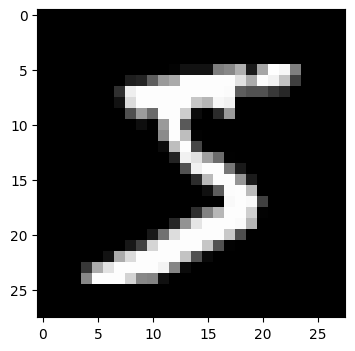

In [146]:
a = train_X[0]
plt.rcParams['figure.figsize'] = (4.0, 4.0)
plt.imshow(a, cmap = "gray")

In [147]:
print(train_X.shape)

(60000, 28, 28)


In [168]:
train_X_flattened = tf.convert_to_tensor(train_X.reshape(train_X.shape[0], -1),dtype=tf.float32)
print(train_X_flattened.shape)
train_y = train_y / 255.0
print(y.shape)

(60000, 784)
(200, 784)


In [169]:
print(train_X_flattened[:5])


tf.Tensor(
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]], shape=(5, 784), dtype=float32)


<h3>/withouttf</h3>

In [56]:
#main training 
alpha = 0.01
epochs = 5
batchsize = 200
weights = []
errors = []
batch_number = 0
K = 1
v0_state = tf.Variable(tf.zeros([784]), tf.float32)
h0_state = tf.Variable(tf.zeros([100]), tf.float32)
hb = tf.Variable(tf.zeros([100]), tf.float32)
vb = tf.Variable(tf.zeros([784]), tf.float32)
W = tf.Variable(tf.zeros([784, 100]), tf.float32)

#creating batches 
# train_ds = create_batches(train_X_flattened, train_y, batchsize)
train_ds = \
    tf.data.Dataset.from_tensor_slices((train_X, train_y)).batch(batchsize).prefetch(tf.data.experimental.AUTOTUNE)

2024-02-25 20:22:39.087750: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 188160000 exceeds 10% of free system memory.


In [57]:
h1_prob = tf.nn.sigmoid(tf.matmul([v1_state], W) + hb)
h1_state = tf.nn.relu(tf.sign(h1_prob - tf.random.uniform(tf.shape(h1_prob)))) #s

In [58]:
print("error: ", error(v0_state, v1_state))

error:  tf.Tensor(0.48979592, shape=(), dtype=float32)


In [49]:
class RBM:
    def __init__(self, n_visible, n_hidden): 
        self.n_visible = n_visible
        self.n_hidden = n_hidden
        self.v0_state = tf.Variable(tf.zeros([n_visible]), tf.float32)
        self.h0_state = tf.Variable(tf.zeros([n_hidden]), tf.float32)
        self.hb = tf.Variable(tf.zeros([n_hidden]), tf.float32)
        self.vb = tf.Variable(tf.zeros([n_visible]), tf.float32)
        self.W = tf.Variable(tf.zeros([n_visible, n_hidden]), tf.float32)

    def hidden_layer(self, v_state):
        h_prob = tf.nn.sigmoid(tf.matmul([v_state], self.W) + self.hb) 
        h_state = tf.nn.relu(tf.sign(h_prob - tf.random.uniform(tf.shape(h_prob)))) 
        return h_state

    def reconstructed_output(self, h_state):
        v_prob = tf.nn.sigmoid(tf.matmul(h_state, tf.transpose(self.W)) + self.vb) 
        v_state = tf.nn.relu(tf.sign(v_prob - tf.random.uniform(tf.shape(v_prob))))
        return v_state[0]

    def error(self, v0_state, v1_state):
        return tf.reduce_mean(tf.square(v0_state - v1_state))

    def train(self, train_ds, learning_rate=0.01, epochs=5, batchsize=32):
        batch_number = 0
        K = 1  # Set K to 1 for now
        
        for epoch in range(epochs):
            for batch_x, batch_y in train_ds: 
                batch_number += 1
                for i_sample in range(batchsize):
                    for k in range(K):
                            v0_state = batch_x[i_sample]
                            h0_state = self.hidden_layer(v0_state)
                            v1_state = self.reconstructed_output(h0_state)
                            h1_state = self.hidden_layer(v1_state)

                            delta_W = tf.matmul(tf.transpose([v0_state]), h0_state) - tf.matmul(tf.transpose([v1_state]), h1_state)
                            self.W = self.W + learning_rate * delta_W
                        
                            delta_vb = tf.reduce_mean(v0_state - v1_state, axis=0)
                            delta_hb = tf.reduce_mean(h0_state - h1_state, axis=0) 
                            self.vb = self.vb + learning_rate * delta_vb
                            self.hb = self.hb + learning_rate * delta_hb
                            
                            v0_state = v1_state

                    if i_sample == batchsize - 1:
                        err = self.error(batch_x[i_sample], v1_state)
                        self.errors.append(err)
                        self.weights.append(W)
                        print('Epoch: %d' % epoch, "batch #: %i " % batch_number, 
                              "of %i" % int(60e3 / batchsize), "sample #: %i" % i_sample,
                              'reconstruction error: %f' % err)
    def save_model(self, filepath):
        variables = { 'W':self.W.numpy(), 
                     'vb':self.vb.numpy(), 
                     'hb':self.hb.numpy()}
        np.savez(filepath, **variables)

    def plot_error():
        plt.plot(errors)
        plt.xlabel("Batch Number")
        plt.ylabel("Error")
        plt.show()
    
    @classmethod
    def load_model(cls, filepath):
        data = np.load(filepath)
        model = cls(data['W'].shape[0], data['W'].shape[1])
        model.W.assign(data['W'])
        model.vb.assign(data['vb'])
        model.hb.assign(data['hb'])
        return model 


In [32]:
train_ds = \
    tf.data.Dataset.from_tensor_slices((train_X, train_y)).batch(200).prefetch(tf.data.experimental.AUTOTUNE)

In [33]:
rbm_mnist  = RBM(28*28, 50)
rbm_mnist.train(train_ds, batchsize=200)


Epoch: 0 batch #: 1  of 300 sample #: 199 reconstruction error: 0.169786
Epoch: 0 batch #: 2  of 300 sample #: 199 reconstruction error: 0.263968
Epoch: 0 batch #: 3  of 300 sample #: 199 reconstruction error: 0.114767
Epoch: 0 batch #: 4  of 300 sample #: 199 reconstruction error: 0.124216
Epoch: 0 batch #: 5  of 300 sample #: 199 reconstruction error: 0.103239
Epoch: 0 batch #: 6  of 300 sample #: 199 reconstruction error: 0.178991
Epoch: 0 batch #: 7  of 300 sample #: 199 reconstruction error: 0.106086
Epoch: 0 batch #: 8  of 300 sample #: 199 reconstruction error: 0.124666
Epoch: 0 batch #: 9  of 300 sample #: 199 reconstruction error: 0.105935
Epoch: 0 batch #: 10  of 300 sample #: 199 reconstruction error: 0.181303
Epoch: 0 batch #: 11  of 300 sample #: 199 reconstruction error: 0.091516
Epoch: 0 batch #: 12  of 300 sample #: 199 reconstruction error: 0.142783
Epoch: 0 batch #: 13  of 300 sample #: 199 reconstruction error: 0.074983
Epoch: 0 batch #: 14  of 300 sample #: 199 reco

In [36]:
variables = {'W':rbm_mnist.W.numpy(),
             'vb':rbm_mnist.vb.numpy(), 
             'hb':rbm_mnist.hb.numpy()}
np.savez('mnist_model.npz',**variables)

In [59]:
for epoch in range(epochs):
    for batch_x, batch_y in train_ds:
        batch_number += 1
        for i_sample in range(batchsize):           
            for k in range(K):
                v0_state = batch_x[i_sample]
                h0_state = hidden_layer(v0_state, W, hb)
                v1_state = reconstructed_output(h0_state, W, vb)
                h1_state = hidden_layer(v1_state, W, hb)

                delta_W = tf.matmul(tf.transpose([v0_state]), h0_state) - tf.matmul(tf.transpose([v1_state]), h1_state)
                W = W + alpha * delta_W

                vb = vb + alpha * tf.reduce_mean(v0_state - v1_state, 0)
                hb = hb + alpha * tf.reduce_mean(h0_state - h1_state, 0) 

                v0_state = v1_state

            if i_sample == batchsize-1:
                err = error(batch_x[i_sample], v1_state)
                errors.append(err)
                weights.append(W)
                print ( 'Epoch: %d' % epoch, 
                       "batch #: %i " % batch_number, "of %i" % int(60e3/batchsize), 
                       "sample #: %i" % i_sample,
                       'reconstruction error: %f' % err)


2024-02-25 20:22:45.810920: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 188160000 exceeds 10% of free system memory.


Epoch: 0 batch #: 1  of 300 sample #: 199 reconstruction error: 0.160262
Epoch: 0 batch #: 2  of 300 sample #: 199 reconstruction error: 0.197572
Epoch: 0 batch #: 3  of 300 sample #: 199 reconstruction error: 0.102527
Epoch: 0 batch #: 4  of 300 sample #: 199 reconstruction error: 0.116448
Epoch: 0 batch #: 5  of 300 sample #: 199 reconstruction error: 0.097712
Epoch: 0 batch #: 6  of 300 sample #: 199 reconstruction error: 0.144662
Epoch: 0 batch #: 7  of 300 sample #: 199 reconstruction error: 0.092520
Epoch: 0 batch #: 8  of 300 sample #: 199 reconstruction error: 0.108369
Epoch: 0 batch #: 9  of 300 sample #: 199 reconstruction error: 0.089068
Epoch: 0 batch #: 10  of 300 sample #: 199 reconstruction error: 0.163616
Epoch: 0 batch #: 11  of 300 sample #: 199 reconstruction error: 0.078556
Epoch: 0 batch #: 12  of 300 sample #: 199 reconstruction error: 0.131644
Epoch: 0 batch #: 13  of 300 sample #: 199 reconstruction error: 0.039744
Epoch: 0 batch #: 14  of 300 sample #: 199 reco

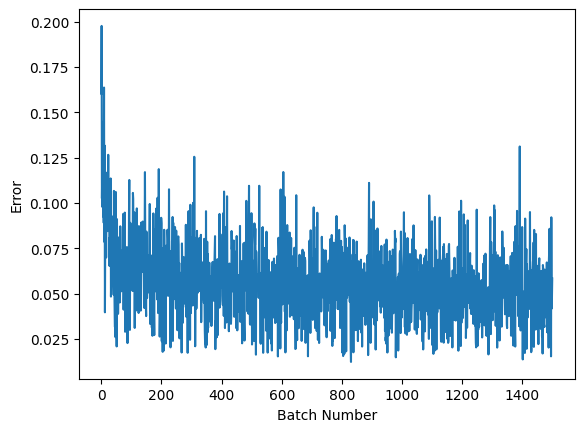

In [60]:
plt.plot(errors)
plt.xlabel("Batch Number")
plt.ylabel("Error")
plt.show()

In [61]:
print(W) # a weight matrix of shape (50,784)
print(W.shape)

tf.Tensor(
[[-0.16       -0.25000003 -0.43999985 ... -0.33999994 -0.22000003
  -0.29      ]
 [-0.19000001 -0.22000003 -0.32999995 ... -0.30999997 -0.16
  -0.21000002]
 [-0.22000003 -0.25000003 -0.3999999  ... -0.35999992 -0.21000002
  -0.30999997]
 ...
 [-0.25000003 -0.30999997 -0.34999993 ... -0.36999992 -0.16
  -0.29999998]
 [-0.22000003 -0.22000003 -0.33999994 ... -0.3799999  -0.16
  -0.29      ]
 [-0.20000002 -0.23000003 -0.3999999  ... -0.33999994 -0.22000003
  -0.29      ]], shape=(784, 100), dtype=float32)
(784, 100)


In [41]:
from utils import tile_raster_images
# tile_raster_images(X=W.numpy().T, img_shape=(28, 28), tile_shape=(5, 10), tile_spacing=(1, 1))

from PIL import Image
# %matplotlib inline
# image = Image.fromarray(tile_raster_images(X=W.numpy().T, img_shape=(28, 28) ,tile_shape=(5, 10), tile_spacing=(1, 1)))
# ### Plot image
# plt.rcParams['figure.figsize'] = (18.0, 18.0)
# imgplot = plt.imshow(image)
# imgplot.set_cmap('gray')  


In [38]:
from PIL import Image
image = Image.fromarray(tile_raster_images(X =W.numpy().T[10:11], img_shape=(28, 28),tile_shape=(1, 1), tile_spacing=(1, 1)))
### Plot image
plt.rcParams['figure.figsize'] = (4.0, 4.0)
imgplot = plt.imshow(image)
imgplot.set_cmap('gray')  

NameError: name 'tile_raster_images' is not defined

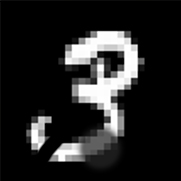

In [42]:
img = Image.open('destructed3.jpg')
img

In [43]:
# convert the image to a 1d numpy array
sample_case = np.array(img.convert('I').resize((28,28))).ravel().reshape((1, -1))/255.0
print(sample_case.shape)
sample_case = tf.cast(sample_case, dtype=tf.float32)




(1, 784)


In [45]:
hh0_p = tf.nn.sigmoid(tf.matmul(sample_case, rbm_mnist.W) + rbm_mnist.hb)
hh0_s = tf.round(hh0_p)

print("Probability nodes in hidden layer:" ,hh0_p)
print("activated nodes in hidden layer:" ,hh0_s)

# reconstruct
vv1_p = tf.nn.sigmoid(tf.matmul(hh0_s, tf.transpose(rbm_mnist.W)) + rbm_mnist.vb)

print(vv1_p)

Probability nodes in hidden layer: tf.Tensor(
[[1.6928244e-21 8.1460457e-18 4.4190702e-07 1.6597673e-04 9.9574298e-01
  5.3334576e-01 9.9899596e-01 6.8700992e-09 9.9998045e-01 9.9999988e-01
  2.5232803e-08 1.9811235e-02 2.3474702e-07 9.9684769e-01 1.0000000e+00
  2.5224016e-14 9.3645680e-18 2.8277797e-11 2.7857328e-12 9.9999332e-01
  1.7072726e-02 2.3439649e-13 3.6078100e-21 7.2441322e-01 5.7562801e-07
  1.8412836e-21 3.4066328e-01 2.5455890e-12 1.3792140e-12 1.4925749e-12
  2.0645099e-09 3.1004292e-03 2.7739479e-05 1.0000000e+00 9.9999416e-01
  9.9742353e-01 3.6316223e-17 9.2087132e-01 1.1867613e-12 7.5054809e-06
  6.3569701e-08 1.9387603e-03 1.0000000e+00 9.9999690e-01 2.5928082e-04
  1.0000000e+00 4.2537897e-13 2.7694591e-11 1.0000000e+00 1.0039902e-23]], shape=(1, 50), dtype=float32)
activated nodes in hidden layer: tf.Tensor(
[[0. 0. 0. 0. 1. 1. 1. 0. 1. 1. 0. 0. 0. 1. 1. 0. 0. 0. 0. 1. 0. 0. 0. 1.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 0. 1. 0. 0. 0. 0. 1. 1. 0. 1. 0. 0.
  1. 0.]]

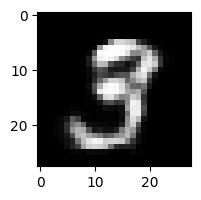

In [48]:
img = Image.fromarray(tile_raster_images(X=vv1_p.numpy(), img_shape=(28, 28),tile_shape=(1, 1), tile_spacing=(1, 1)))
plt.rcParams['figure.figsize'] = (2.0, 2.0)
imgplot = plt.imshow(img)
imgplot.set_cmap('gray') 

In [140]:
import tensorflow_datasets as tfds
datasets_list = tfds.list_builders()
if 'mnist_corrupted' in datasets_list: 
    mnist_corrputed = tfds.load(name='mnist_corrupted/zigzag')

In [13]:
mnist_corrupted = tfds.load(name='mnist_corrupted/zigzag', split='train')

In [14]:
print(mnist_corrupted)

<_PrefetchDataset element_spec={'image': TensorSpec(shape=(28, 28, 1), dtype=tf.uint8, name=None), 'label': TensorSpec(shape=(), dtype=tf.int64, name=None)}>


In [19]:
sample_data = mnist_corrupted.take(5)
x = []
for i in sample_data:
    x.append(i)
# image = sample_data[0]['image'].numpy().squeeze()  # Convert to NumPy array and remove the single-dimensional entries
# label = sample_data[0]['label'].numpy()

# # Display the image and label using Matplotlib
# plt.figure()
# plt.imshow(image, cmap='gray')  # Display the image in grayscale
# plt.title(f'Label: {label}')
# plt.axis('off')  # Turn off axis
# plt.show()

2024-02-25 20:15:42.935828: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


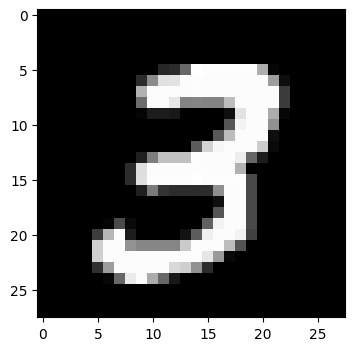

In [243]:
img4 = train_X[7]
img4 = tf.cast(img4, dtype=tf.float32)
img4 = tf.reshape(img4, [28, 28]) 
# imgdis = Image.fromarray(tile_raster_images(X=img4.numpy(), img_shape=(28, 28),tile_shape=(1, 1), tile_spacing=(1, 1)))
# plt.rcParams['figure.figsize'] = (4.0, 4.0)
# imgplot = plt.imshow(imgdis)
# imgplot.set_cmap('gray') 
plt.rcParams['figure.figsize'] = (4.0, 4.0)

plt.imshow(img4)
plt.set_cmap('gray')

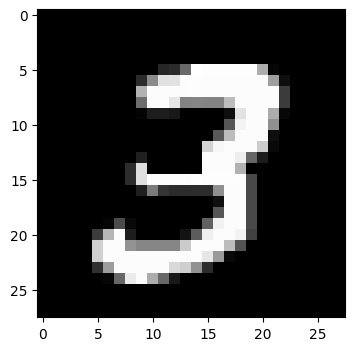

In [238]:
img4 = img4.numpy()
for i in range(10, 15):
    for j in range(10, 15): 
        img4[i][j] = 0

plt.rcParams['figure.figsize'] = (4.0, 4.0)

plt.imshow(img4)
plt.set_cmap('gray')

In [252]:
img4 = tf.cast(tf.reshape(tf.convert_to_tensor(img4), [1, -1]), tf.float32) 
print(img4.shape)


(1, 784)


In [246]:
prediction_h0 = tf.nn.sigmoid(tf.matmul(img4, W) + hb)
prediction_h0s = tf.round(prediction_h0)

#reconstruct 
prediction_v0 = tf.nn.sigmoid(tf.matmul(prediction_h0s, tf.transpose(W)) + vb)


In [247]:
prediction_v0 = prediction_v0 
print(prediction_v0.shape)

(1, 784)


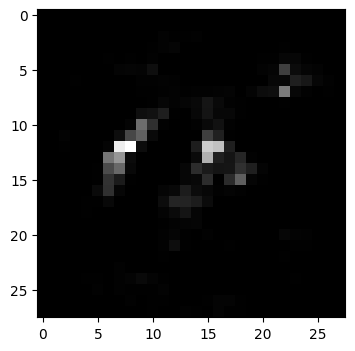

In [248]:
img = Image.fromarray(tile_raster_images(X=prediction_v0.numpy(), img_shape=(28, 28),tile_shape=(1, 1), tile_spacing=(1, 1)))
plt.rcParams['figure.figsize'] = (4.0, 4.0)
imgplot = plt.imshow(img)
imgplot.set_cmap('gray') 